In [2]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import json
from collections import Counter

from sklearn.datasets import make_classification
from sklearn.ensemble import ExtraTreesClassifier

from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.svm import LinearSVC
from sklearn.datasets import load_iris
from sklearn.feature_selection import SelectFromModel

from sklearn.linear_model import LassoCV
from time import time
import warnings
warnings.filterwarnings('ignore')

In [3]:

df = pd.read_csv("../../../our_data/Etap5/Etap3/all_for_FI.csv")

In [4]:
df.shape

(16990, 55)

## Spearman correlation between atributes

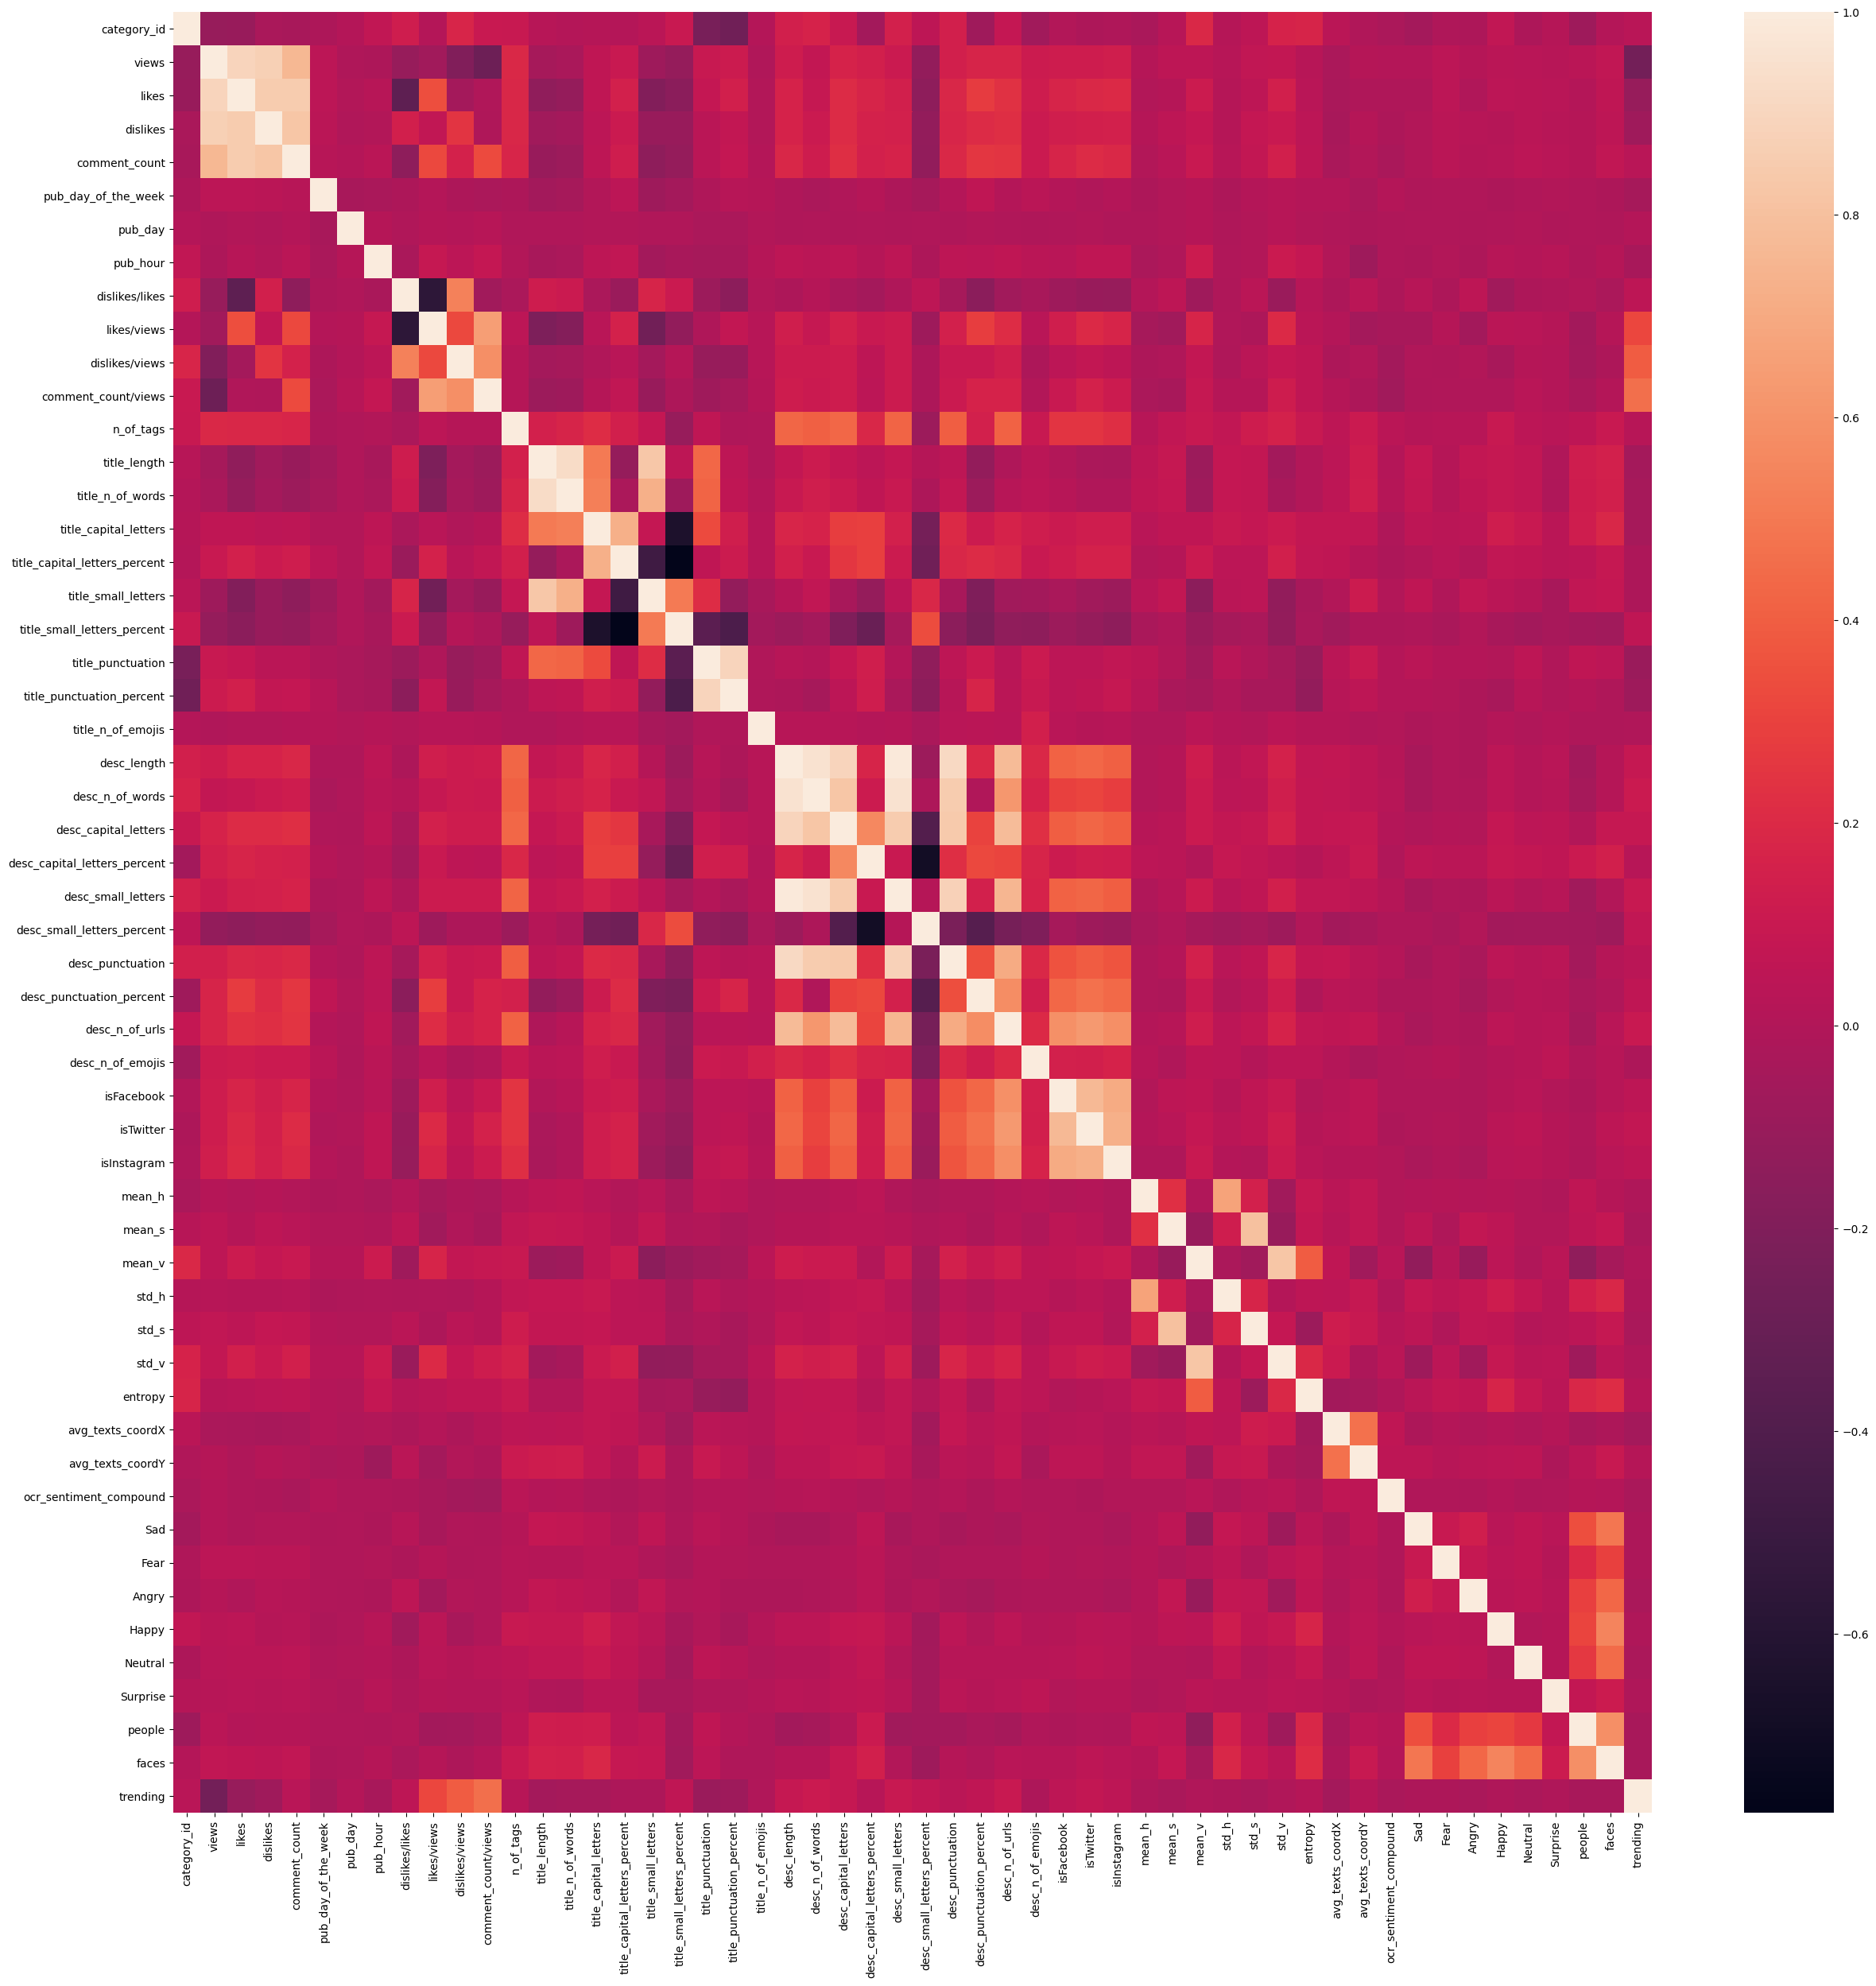

In [6]:
corr = df.corr(method='spearman')
plt.figure(figsize=(30,30),dpi=100)
sns.heatmap(corr)
plt.savefig("../../../our_data/Etap5/Etap3/corr_spearman.pdf")
plt.show()

In [7]:
df.columns

Index(['video_id', 'category_id', 'views', 'likes', 'dislikes',
       'comment_count', 'pub_day_of_the_week', 'pub_day', 'pub_hour',
       'dislikes/likes', 'likes/views', 'dislikes/views',
       'comment_count/views', 'n_of_tags', 'title_length', 'title_n_of_words',
       'title_capital_letters', 'title_capital_letters_percent',
       'title_small_letters', 'title_small_letters_percent',
       'title_punctuation', 'title_punctuation_percent', 'title_n_of_emojis',
       'desc_length', 'desc_n_of_words', 'desc_capital_letters',
       'desc_capital_letters_percent', 'desc_small_letters',
       'desc_small_letters_percent', 'desc_punctuation',
       'desc_punctuation_percent', 'desc_n_of_urls', 'desc_n_of_emojis',
       'isFacebook', 'isTwitter', 'isInstagram', 'mean_h', 'mean_s', 'mean_v',
       'std_h', 'std_s', 'std_v', 'entropy', 'avg_texts_coordX',
       'avg_texts_coordY', 'ocr_sentiment_compound', 'Sad', 'Fear', 'Angry',
       'Happy', 'Neutral', 'Surprise', 'people',

In [8]:
pd.set_option('display.max_columns', None)

def prepeareData(df):
    df = df[ df['trending'].notna() ]
    y = df.loc[:,'trending']
    X  = df.loc[:, df.columns != 'trending']
    X = X.select_dtypes(include=np.number)
    X = X.fillna(-1)
    return X, y


def getFI_RForest(X,y,printF= True,plot = True):
    forest = ExtraTreesClassifier(n_estimators=250,
                                  random_state=0)

    forest.fit(X, y)
    importances = forest.feature_importances_
    std = np.std([tree.feature_importances_ for tree in forest.estimators_],
                 axis=0)
    indices = np.argsort(importances)[::-1]
    df = pd.DataFrame(np.dstack([importances,X.columns])[0])
    if plot:    
        plt.figure(figsize=(10,10))

        plt.title("Feature importances")
        plt.bar(range(X.shape[1]), importances[indices],
                color="r", yerr=std[indices], align="center")
#         plt.bar(range(X.shape[1]), x=np.arange(0,len(df)),
#                 color="r", yerr=std[indices], align="center")
#         plt.xticks(range(X.shape[1]), indices)
        plt.xlim([-1, X.shape[1]])
        plt.show()
    if printF: 
        print("Feature ranking:")
        for f in range(X.shape[1]):
            print("%d. feature %s (%f)" % (f + 1, X.columns[indices[f]], importances[indices[f]]))

    
    return df.sort_values(by=0,ascending=False)

def getFI_Bagging(X,y,printF= True,plot = True):
    clf = BaggingClassifier(DecisionTreeClassifier())
    clf.fit(X, y)

    feature_importances = np.mean([
        tree.feature_importances_ for tree in clf.estimators_
    ], axis=0)

    df = pd.DataFrame(np.dstack([feature_importances,X.columns])[0])
    
    indices = np.argsort(feature_importances)[::-1]

    if plot:
        
        plt.figure(figsize=(10,10))
            
        plt.title("Feature importances")
        plt.bar(range(X.shape[1]), feature_importances[indices],
                color="r",  align="center")
#         plt.bar(range(X.shape[1]),
#                 color="r",  align="center")
#         plt.xticks(range(X.shape[1]), indices)
        plt.xlim([-1, X.shape[1]])
        plt.show()
    if printF: 
        print("Feature ranking:")
        for f in range(X.shape[1]):
            print("%d. feature %s (%f)" % (f + 1, X.columns[indices[f]], feature_importances[indices[f]]))
            
    return df.sort_values(by=0,ascending=False)

def selectFromModelSVC(X,y,printF= True,plot = True):
    lsvc = LinearSVC(C=0.01, penalty="l1", dual=False).fit(X, y)
    model = SelectFromModel(lsvc, prefit=True)
    X_new = model.transform(X)
    feature_idx = model.get_support()
    feature_name = X.columns[feature_idx]    
    if printF:
        print("Before: "+ str(X.shape))
        print("After: "+ str(X_new.shape))        
        print(feature_name)
    return feature_name
def getFILasso(X,y,printF= True,plot = True):
    lasso = LassoCV().fit(X, y)
    importance = np.abs(lasso.coef_)
    feature_names = np.array(X.columns)

    df = pd.DataFrame(np.dstack([importance,X.columns])[0])
    df = df.sort_values(by=0,ascending=False)
    if plot:
        plt.figure(figsize=(10,10))

        plt.bar(height=df[0], x=np.arange(0,len(df)))
        plt.title("Feature importances via coefficients")
        plt.show()
    if printF:
        pd.set_option('display.max_rows', None)        
        print(df.sort_values(by=0,ascending=False))
        pd.set_option('display.max_rows', 20)        

    return df.sort_values(by=0,ascending=False)
    
    


# Feature importance

In [9]:
X, y = prepeareData(df)
print(df.shape)
df

(16990, 55)


,video_id,category_id,views,likes,dislikes,comment_count,pub_day_of_the_week,pub_day,pub_hour,dislikes/likes,likes/views,dislikes/views,comment_count/views,n_of_tags,title_length,title_n_of_words,title_capital_letters,title_capital_letters_percent,title_small_letters,title_small_letters_percent,title_punctuation,title_punctuation_percent,title_n_of_emojis,desc_length,desc_n_of_words,desc_capital_letters,desc_capital_letters_percent,desc_small_letters,desc_small_letters_percent,desc_punctuation,desc_punctuation_percent,desc_n_of_urls,desc_n_of_emojis,isFacebook,isTwitter,isInstagram,mean_h,mean_s,mean_v,std_h,std_s,std_v,entropy,avg_texts_coordX,avg_texts_coordY,ocr_sentiment_compound,Sad,Fear,Angry,Happy,Neutral,Surprise,people,faces,trending
0,tOpTQ3Fuf9s,10,0.522451,2.943601,0.007986,0.920714,1.779362,0.793851,-0.219590,-0.181688,-0.054449,-0.065806,-0.021313,2.716688,0.289196,0.011139,-0.400511,-0.516403,-0.545520,-1.017732,1.961436,1.700950,-0.098746,-0.997704,-0.870119,-0.630365,0.819610,-1.023449,-1.317247,-0.602039,-0.784991,-0.887171,-0.248385,0,0,0,0.974207,-1.275044,-0.080489,1.107219,-1.075142,-0.742505,0.256621,-1.185383,-1.423955,-0.115386,-0.442328,-0.291643,-0.403087,-0.553750,-0.481588,-0.11798,2.872551,-0.781681,0
1,k0DqRstCgj4,10,2.073490,8.162990,0.147273,4.719335,-1.471729,1.261720,0.231302,-0.177401,-0.229012,-0.065349,-0.021312,2.797176,-0.361339,-0.268399,-0.164737,-0.053177,-1.325168,-1.870503,3.525294,4.447726,-0.098746,-0.912770,-0.709958,-0.427639,2.439801,-1.007130,-2.648998,-0.498959,-0.371932,-0.887171,-0.248385,0,0,0,-0.200788,1.089185,-1.525329,1.542963,1.556973,-1.308896,-1.477956,0.050411,1.038159,-0.115386,-0.442328,-0.291643,-0.403087,-0.553750,-0.481588,-0.11798,0.517372,-0.781681,0
2,1CYH4F1KCw8,10,1.214069,6.528692,0.137712,3.771792,-0.388032,0.325981,0.231302,-0.175135,-0.056146,-0.062976,-0.021310,2.716688,0.639484,0.290677,-0.164737,-0.415426,-0.480550,-1.146115,3.525294,2.679282,-0.098746,-0.912770,-0.709958,-0.427639,2.439801,-1.007130,-2.648998,-0.498959,-0.371932,-0.887171,-0.248385,0,0,0,1.402899,0.107901,0.546908,-0.526075,0.621568,0.829999,0.630587,0.050411,1.042783,-0.115386,-0.442328,-0.291643,-0.403087,-0.553750,-0.481588,-0.11798,1.348612,-0.781681,0
3,UdjEoGzXxmI,10,0.163359,1.634717,-0.009439,0.692539,-1.471729,0.910818,0.231302,-0.181130,0.239992,-0.063887,-0.021308,-0.985750,0.289196,-0.547937,-0.046850,-0.218131,-0.610491,-1.109026,4.567867,4.127820,-0.098746,-0.997704,-0.887915,-0.606038,1.490034,-1.025262,-1.425519,-0.516139,0.653525,-0.887171,-0.248385,0,0,0,-0.604300,-1.483410,0.964161,-0.216254,-1.422896,0.197303,-0.068919,-1.185383,-1.423955,-0.115386,-0.442328,-0.291643,-0.403087,-0.553750,-0.481588,-0.11798,0.932992,-0.781681,0
4,cD8SYW8rjaQ,10,0.968084,5.297738,0.086113,3.887045,1.779362,-1.311564,0.231302,-0.177162,-0.050280,-0.063806,-0.021307,0.221566,-0.961833,-0.827475,0.188925,0.912821,-1.909904,-2.934909,1.961436,3.976141,-0.098746,-0.912770,-0.709958,-0.427639,2.439801,-1.007130,-2.648998,-0.498959,-0.371932,-0.887171,-0.248385,0,0,0,-0.907744,0.488066,-1.120820,-0.681140,0.645923,-0.690448,-0.005110,-0.087127,0.290278,-0.115386,2.232788,-0.291643,-0.403087,-0.553750,2.763068,-0.11798,1.071532,1.356148,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16985,zvFQWPEuNJA,24,-0.069865,-0.173854,-0.030374,-0.164515,-1.471729,-0.726727,-0.520185,-0.113742,-0.289246,-0.047629,-0.021307,0.463030,-1.111957,-1.107013,-0.518398,-0.039853,-0.740432,0.295015,-0.644996,-0.257283,-0.098746,0.427030,0.215417,0.026468,-0.301487,0.541335,0.422330,-0.138178,0.368561,1.598099,-0.248385,1,1,1,-1.275016,0.988842,0.269349,-1.262519,0.868762,1.260938,0.320593,-0.246367,0.630284,1.509876,0.895230,-0.291643,-0.403087,-0.553750,-0.481588,-0.11798,-0.313867,-0.247224,1
16986,zvjqcoiOPbE,10,-0.079661,-0.1285

## Feature Importance based on Random Forest

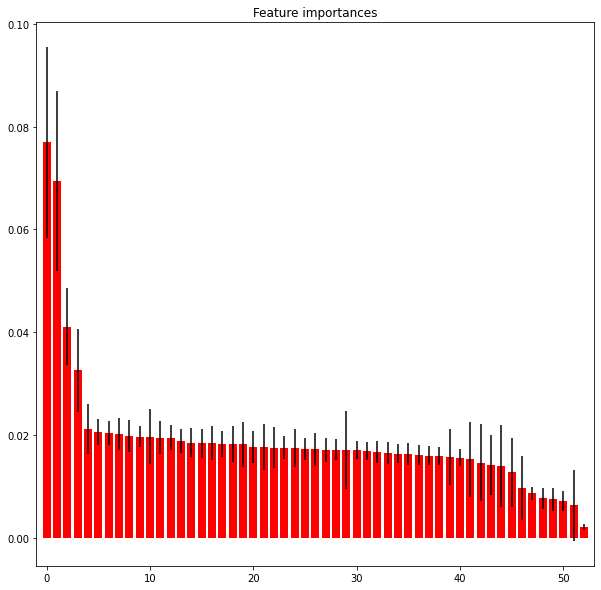

Feature ranking:
1. feature likes/views (0.076919)
2. feature comment_count/views (0.069423)
3. feature dislikes/views (0.041025)
4. feature views (0.032562)
5. feature avg_texts_coordX (0.021185)
6. feature dislikes/likes (0.020572)
7. feature category_id (0.020301)
8. feature likes (0.020122)
9. feature desc_n_of_words (0.019721)
10. feature pub_hour (0.019661)
11. feature avg_texts_coordY (0.019620)
12. feature n_of_tags (0.019462)
13. feature desc_small_letters_percent (0.019454)
14. feature desc_punctuation_percent (0.018836)
15. feature desc_n_of_urls (0.018496)
16. feature desc_length (0.018355)
17. feature desc_small_letters (0.018322)
18. feature title_punctuation (0.018217)
19. feature mean_v (0.018215)
20. feature std_s (0.018187)
21. feature std_v (0.017689)
22. feature entropy (0.017556)
23. feature std_h (0.017525)
24. feature desc_punctuation (0.017521)
25. feature mean_s (0.017455)
26. feature title_punctuation_percent (0.017187)
27. feature mean_h (0.017176)
28. featur

In [10]:
r1 = getFI_RForest(X,y)

## Feature Importance based on Bagging + Decision tree

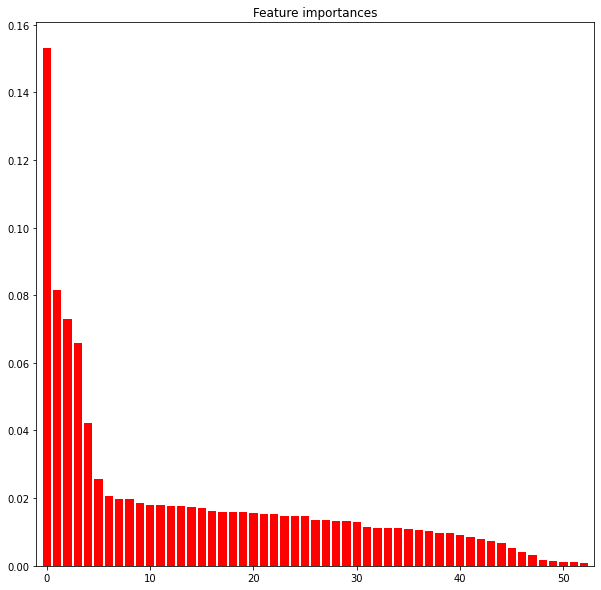

Feature ranking:
1. feature dislikes/views (0.153049)
2. feature likes/views (0.081510)
3. feature comment_count/views (0.072953)
4. feature views (0.065881)
5. feature n_of_tags (0.042302)
6. feature desc_small_letters_percent (0.025677)
7. feature desc_n_of_words (0.020518)
8. feature desc_capital_letters_percent (0.019755)
9. feature std_v (0.019625)
10. feature likes (0.018671)
11. feature pub_hour (0.017857)
12. feature dislikes/likes (0.017853)
13. feature title_punctuation_percent (0.017608)
14. feature entropy (0.017598)
15. feature title_capital_letters_percent (0.017504)
16. feature desc_punctuation_percent (0.017201)
17. feature title_small_letters_percent (0.016345)
18. feature dislikes (0.015893)
19. feature std_s (0.015876)
20. feature desc_length (0.015851)
21. feature desc_punctuation (0.015491)
22. feature avg_texts_coordX (0.015427)
23. feature mean_v (0.015253)
24. feature mean_s (0.014716)
25. feature category_id (0.014677)
26. feature avg_texts_coordY (0.014594)
27

In [11]:
r3 = getFI_Bagging(X,y)

## Feature Importance based on LassoCV

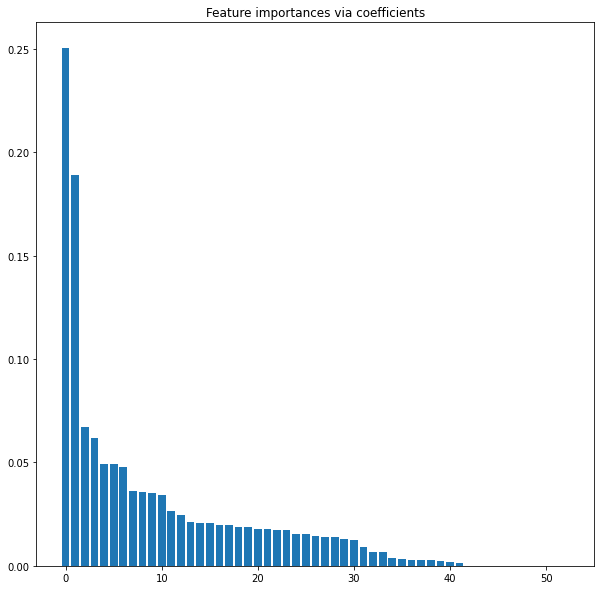

             0                              1
9     0.250275                    likes/views
10    0.188993                 dislikes/views
23   0.0672582                desc_n_of_words
2    0.0619122                          likes
8    0.0494035                 dislikes/likes
22   0.0493701                    desc_length
52   0.0476293                          faces
49   0.0362486                        Neutral
19   0.0358831              title_punctuation
48    0.035099                          Happy
42   0.0342589               avg_texts_coordX
47   0.0262791                          Angry
4    0.0244239                  comment_count
28   0.0210326               desc_punctuation
45   0.0208931                            Sad
30   0.0206867                 desc_n_of_urls
44   0.0196699         ocr_sentiment_compound
46   0.0196582                           Fear
3    0.0186376                       dislikes
24   0.0185425           desc_capital_letters
7    0.0177537                    

In [12]:
r2 = getFILasso(X,y)

## Selecting features based on  LinearSVC and sklearn SelectFromModel

In [13]:
r4 = selectFromModelSVC(X,y)

Before: (16990, 53)
After: (16990, 43)
Index(['category_id', 'views', 'likes', 'comment_count', 'pub_day_of_the_week',
       'pub_hour', 'dislikes/likes', 'likes/views', 'dislikes/views',
       'comment_count/views', 'n_of_tags', 'title_n_of_words',
       'title_capital_letters_percent', 'title_small_letters',
       'title_punctuation', 'title_punctuation_percent', 'desc_length',
       'desc_n_of_words', 'desc_capital_letters',
       'desc_capital_letters_percent', 'desc_small_letters_percent',
       'desc_punctuation', 'desc_punctuation_percent', 'desc_n_of_urls',
       'desc_n_of_emojis', 'isTwitter', 'mean_s', 'mean_v', 'std_h', 'std_s',
       'std_v', 'entropy', 'avg_texts_coordX', 'avg_texts_coordY',
       'ocr_sentiment_compound', 'Sad', 'Fear', 'Angry', 'Happy', 'Neutral',
       'Surprise', 'people', 'faces'],
      dtype='object')


In [18]:
df.loc[df['trending'] == 1]

,video_id,category_id,views,likes,dislikes,comment_count,pub_day_of_the_week,pub_day,pub_hour,dislikes/likes,likes/views,dislikes/views,comment_count/views,n_of_tags,title_length,title_n_of_words,title_capital_letters,title_capital_letters_percent,title_small_letters,title_small_letters_percent,title_punctuation,title_punctuation_percent,title_n_of_emojis,desc_length,desc_n_of_words,desc_capital_letters,desc_capital_letters_percent,desc_small_letters,desc_small_letters_percent,desc_punctuation,desc_punctuation_percent,desc_n_of_urls,desc_n_of_emojis,isFacebook,isTwitter,isInstagram,mean_h,mean_s,mean_v,std_h,std_s,std_v,entropy,avg_texts_coordX,avg_texts_coordY,ocr_sentiment_compound,Sad,Fear,Angry,Happy,Neutral,Surprise,people,faces,trending
8481,-3VBPAZPTQI,22,-0.082890,-0.185615,-0.036171,-0.195047,0.695665,1.612623,0.231302,-0.161132,0.514782,-0.046448,-0.021295,-0.502824,-0.161174,-0.268399,3.371875,3.392213,-1.909904,-2.934909,-0.123710,-0.058531,-0.098746,3.983482,2.075065,3.748525,0.588375,3.614694,-0.317396,2.456012,0.959375,5.522209,-0.248385,0,1,1,-1.453392,-0.311721,0.583510,-1.321724,-0.397531,-0.196766,0.469784,-1.185383,-1.423955,-0.115386,-0.442328,-0.291643,1.241564,0.610413,-0.481588,-0.11798,-0.313867,0.287234,1
8482,-43MBOJnVks,24,-0.074224,-0.200115,-0.033171,-0.177684,-0.929881,-0.258857,0.531897,-0.103003,-0.395371,-0.050399,-0.021306,0.784981,-0.911792,-0.827475,1.603569,2.909215,-1.909904,-2.934909,0.397577,1.303826,-0.098746,2.451085,2.884768,1.177954,-0.198062,2.731670,0.434478,1.803169,-0.525064,-0.887171,-0.248385,0,0,0,0.136210,-1.319733,0.019152,-0.587651,-1.304023,-1.167200,-0.210938,-1.185383,-1.423955,-0.115386,-0.442328,-0.291643,1.241564,-0.553750,-0.481588,-0.11798,-0.452407,-0.247224,1
8483,-5WBCrazSfg,17,-0.083848,-0.216914,-0.037866,-0.203962,-1.471729,1.378688,0.832492,-0.164479,-0.143788,-0.059781,-0.021296,0.865469,0.939731,0.849753,-0.282624,-0.564695,0.948805,0.336030,1.440149,0.764871,5.401882,-0.404364,-0.354045,-0.143822,0.495276,-0.408777,0.028589,-0.378698,-0.067006,-0.363956,-0.248385,1,1,1,-1.101069,-0.611874,-0.225399,-0.990396,-0.007340,0.816029,0.373197,0.935174,1.243913,1.161533,-0.442328,-0.291643,-0.403087,0.610413,-0.481588,-0.11798,-0.452407,-0.247224,1
8484,-5aaJJQFvOg,10,-0.075133,0.145823,-0.024492,0.026077,-0.388032,0.676883,1.283384,-0.168693,3.099048,-0.017434,-0.021259,-0.905263,-0.361339,-0.268399,-0.046850,0.075623,-0.350608,-0.096491,0.397577,0.675046,-0.098746,-0.181862,-0.514206,-0.022186,0.330109,-0.149490,0.232880,-0.430239,0.889510,0.682473,-0.248385,1,1,0,2.225753,-0.268056,0.301262,1.245253,0.018124,0.688371,0.584025,-1.185383,-1.423955,-0.115386,0.895230,2.639269,-0.403087,2.938738,2.763068,-0.11798,0.378833,2.959520,1
8485,-7tSTUR7FG0,10,-0.060070,0.468660,-0.033035,0.243822,-0.929881,1.378688,-0.219590,-0.185475,2.559324,-0.059737,-0.021268,2.394737,-0.911792,-0.547937,-0.046850,0.504955,-1.195227,-1.200321,-0.123710,0.465452,-0.098746,-0.684287,-0.763345,-0.435748,0.168766,-0.698887,-0.105315,-0.550499,1.410593,-0.102349,-0.248385,1,1,1,-0.138693,-1.672758,0.585839,0.179871,-1.331185,-0.158244,0.186482,-1.185383,-1.423955,-0.115386,-0.442328,-0.291643,-0.403087,-0.553750,-0.481588,-0.11798,0.655912,-0.781681,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16985,zvFQWPEuNJA,24,-0.069865,-0.173854,-0.030374,-0.164515,-1.471729,-0.726727,-0.520185,-0.113742,-0.289246,-0.047629,-0.021307,0.463030,-1.111957,-1.107013,-0.518398,-0.039853,-0.740432,0.295015,-0.644996,-0.257283,-0.098746,0.427030,0.215417,0.026468,-0.301487,0.541335,0.422330,-0.138178,0.368561,1.598099,-0.248385,1,1,1,-1.275016,0.988842,0.269349,-1.262519,0.868762,1.260938,0.320593,-0.246367,0.630284,1.509876,0.895230,-0.291643,-0.403087,-0.553750,-0.481588,-0.11798,-0.313867,-0.247224,1
16986,zvjqcoiOPbE,10,-0.07

In [19]:
df.loc[df['trending'] == 0]

,video_id,category_id,views,likes,dislikes,comment_count,pub_day_of_the_week,pub_day,pub_hour,dislikes/likes,likes/views,dislikes/views,comment_count/views,n_of_tags,title_length,title_n_of_words,title_capital_letters,title_capital_letters_percent,title_small_letters,title_small_letters_percent,title_punctuation,title_punctuation_percent,title_n_of_emojis,desc_length,desc_n_of_words,desc_capital_letters,desc_capital_letters_percent,desc_small_letters,desc_small_letters_percent,desc_punctuation,desc_punctuation_percent,desc_n_of_urls,desc_n_of_emojis,isFacebook,isTwitter,isInstagram,mean_h,mean_s,mean_v,std_h,std_s,std_v,entropy,avg_texts_coordX,avg_texts_coordY,ocr_sentiment_compound,Sad,Fear,Angry,Happy,Neutral,Surprise,people,faces,trending
0,tOpTQ3Fuf9s,10,0.522451,2.943601,0.007986,0.920714,1.779362,0.793851,-0.219590,-0.181688,-0.054449,-0.065806,-0.021313,2.716688,0.289196,0.011139,-0.400511,-0.516403,-0.545520,-1.017732,1.961436,1.700950,-0.098746,-0.997704,-0.870119,-0.630365,0.819610,-1.023449,-1.317247,-0.602039,-0.784991,-0.887171,-0.248385,0,0,0,0.974207,-1.275044,-0.080489,1.107219,-1.075142,-0.742505,0.256621,-1.185383,-1.423955,-0.115386,-0.442328,-0.291643,-0.403087,-0.553750,-0.481588,-0.11798,2.872551,-0.781681,0
1,k0DqRstCgj4,10,2.073490,8.162990,0.147273,4.719335,-1.471729,1.261720,0.231302,-0.177401,-0.229012,-0.065349,-0.021312,2.797176,-0.361339,-0.268399,-0.164737,-0.053177,-1.325168,-1.870503,3.525294,4.447726,-0.098746,-0.912770,-0.709958,-0.427639,2.439801,-1.007130,-2.648998,-0.498959,-0.371932,-0.887171,-0.248385,0,0,0,-0.200788,1.089185,-1.525329,1.542963,1.556973,-1.308896,-1.477956,0.050411,1.038159,-0.115386,-0.442328,-0.291643,-0.403087,-0.553750,-0.481588,-0.11798,0.517372,-0.781681,0
2,1CYH4F1KCw8,10,1.214069,6.528692,0.137712,3.771792,-0.388032,0.325981,0.231302,-0.175135,-0.056146,-0.062976,-0.021310,2.716688,0.639484,0.290677,-0.164737,-0.415426,-0.480550,-1.146115,3.525294,2.679282,-0.098746,-0.912770,-0.709958,-0.427639,2.439801,-1.007130,-2.648998,-0.498959,-0.371932,-0.887171,-0.248385,0,0,0,1.402899,0.107901,0.546908,-0.526075,0.621568,0.829999,0.630587,0.050411,1.042783,-0.115386,-0.442328,-0.291643,-0.403087,-0.553750,-0.481588,-0.11798,1.348612,-0.781681,0
3,UdjEoGzXxmI,10,0.163359,1.634717,-0.009439,0.692539,-1.471729,0.910818,0.231302,-0.181130,0.239992,-0.063887,-0.021308,-0.985750,0.289196,-0.547937,-0.046850,-0.218131,-0.610491,-1.109026,4.567867,4.127820,-0.098746,-0.997704,-0.887915,-0.606038,1.490034,-1.025262,-1.425519,-0.516139,0.653525,-0.887171,-0.248385,0,0,0,-0.604300,-1.483410,0.964161,-0.216254,-1.422896,0.197303,-0.068919,-1.185383,-1.423955,-0.115386,-0.442328,-0.291643,-0.403087,-0.553750,-0.481588,-0.11798,0.932992,-0.781681,0
4,cD8SYW8rjaQ,10,0.968084,5.297738,0.086113,3.887045,1.779362,-1.311564,0.231302,-0.177162,-0.050280,-0.063806,-0.021307,0.221566,-0.961833,-0.827475,0.188925,0.912821,-1.909904,-2.934909,1.961436,3.976141,-0.098746,-0.912770,-0.709958,-0.427639,2.439801,-1.007130,-2.648998,-0.498959,-0.371932,-0.887171,-0.248385,0,0,0,-0.907744,0.488066,-1.120820,-0.681140,0.645923,-0.690448,-0.005110,-0.087127,0.290278,-0.115386,2.232788,-0.291643,-0.403087,-0.553750,2.763068,-0.11798,1.071532,1.356148,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8476,-bx0e_kHaA4,26,-0.042383,0.083933,-0.017779,-0.212120,-0.929881,-0.609759,0.231302,-0.152521,0.181055,-0.047543,-0.021317,1.026444,1.590266,1.408829,0.188925,-0.393022,1.403600,0.262586,2.482722,1.122010,-0.098746,3.763372,3.561004,3.489035,0.557556,3.123320,-0.609612,1.957790,0.631711,7.222656,-0.248385,1,1,1,0.258511,-0.235332,1.961503,0.887246,0.296150,1.271607,0.335681,-0.200032,0.562690,-0.115386,-0.442328,-0.291643,-0.403087,0.610413,-0.481588,-0.11798,-0.313867,-0.247224,0
8477,tcxmGrBlrhU,26,-0.081702,-0.180887,-0.037171

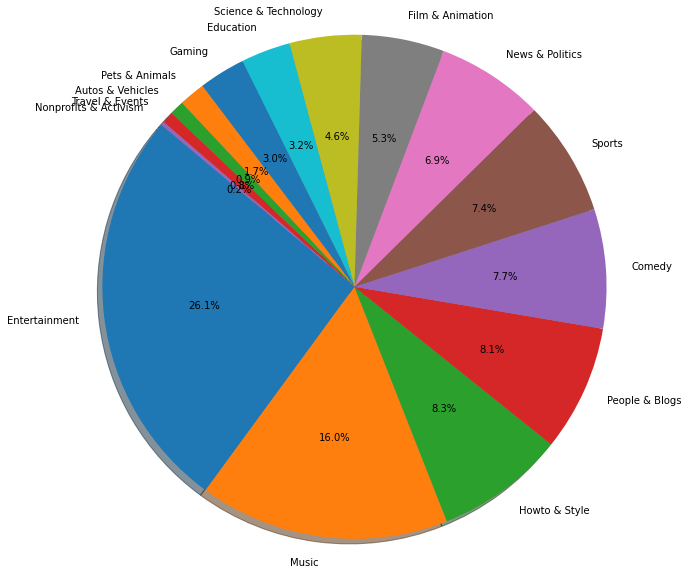

In [22]:
with open("./../../../data/youtube_data/US_category_id.json") as file:
    data = json.loads(file.read())
    
US_cats = {}
for item in data['items']:
    US_cats[item['id']] = item['snippet']['title']

df_temp =df.loc[df['trending'] == 1]

# gbCtr = Counter(df.loc[:, "category_id"]).most_common()
gbCtr = Counter(df_temp.loc[:, "category_id"]).most_common()
gbCatdata = []
gbCatlabels = []
for c in gbCtr:
    try:
        gbCatlabels.append(US_cats[str(int(c[0]))])
        gbCatdata.append(c[1])
    except:
        print("error")


plt.figure(figsize=(10,10))
plt.pie(gbCatdata, labels=gbCatlabels ,autopct='%1.1f%%', shadow=True, startangle=140)

plt.axis('equal')
plt.show()


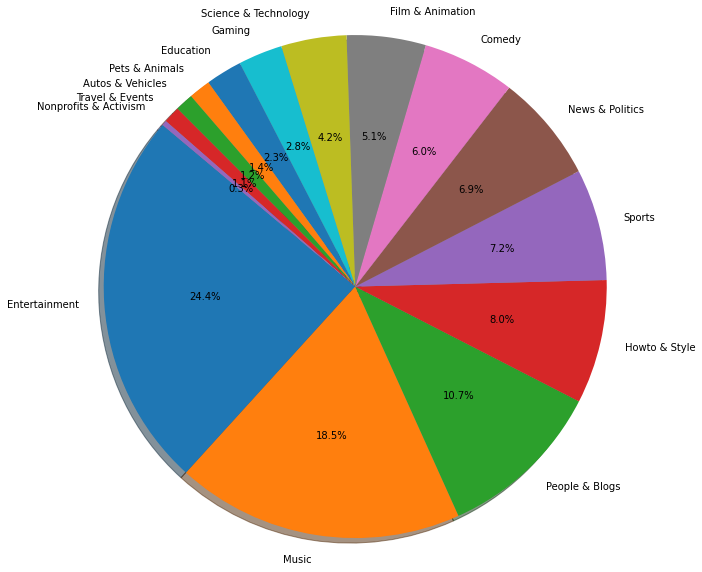

In [23]:
with open("./../../../data/youtube_data/US_category_id.json") as file:
    data = json.loads(file.read())
    
US_cats = {}
for item in data['items']:
    US_cats[item['id']] = item['snippet']['title']



df_temp =df.loc[df['trending'] == 0]

# gbCtr = Counter(df.loc[:, "category_id"]).most_common()
gbCtr = Counter(df_temp.loc[:, "category_id"]).most_common()
gbCatdata = []
gbCatlabels = []
for c in gbCtr:
    try:
        gbCatlabels.append(US_cats[str(int(c[0]))])
        gbCatdata.append(c[1])
    except:
        print("error")


plt.figure(figsize=(10,10))
plt.pie(gbCatdata, labels=gbCatlabels ,autopct='%1.1f%%', shadow=True, startangle=140)

plt.axis('equal')
plt.show()
